In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, Reshape, Conv2DTranspose
from keras.optimizers import Adam
import time
from tensorflow.keras.datasets import mnist # Import mnist from tensorflow.keras.datasets


In [ ]:
def load_real_samples():
    (X_train, _), (_, _) = mnist.load_data()
    if K.image_data_format() == 'channels_first':
        X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
        input_shape = (1, X_train.shape[1], X_train.shape[2])
    else:
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
        input_shape = (X_train.shape[1], X_train.shape[2], 1)
    #normalize
    X_train = (X_train - X_train.min())/(X_train.max() - X_train.min())

    return X_train, input_shape

In [ ]:
dataset, input_shape = load_real_samples()
print(dataset.shape)
print(input_shape)

(60000, 28, 28, 1)
(28, 28, 1)


In [ ]:
def generate_real_samples(X_train, n_samples):
    idx = np.random.randint(0, X_train.shape[0], n_samples)   # X_train.shape[0] or 60000
    X = X_train[idx,:,:,:] # <====60000, 28, 28, 1
    y = np.ones((n_samples,1))
    # Label=1 indicates the data is real
    # Label=0 indicates the data is fake
    return X, y


Shape of X (samples): (10, 28, 28, 1)
Shape of y (labels): (10, 1)


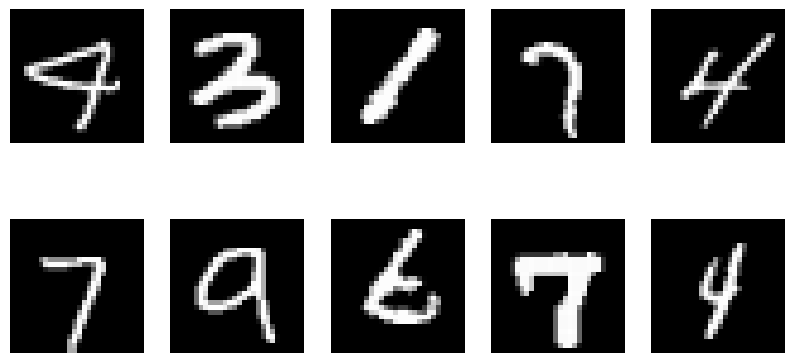

In [ ]:
# Generate 10 real samples
n_samples = 10
samples, labels = generate_real_samples(dataset, n_samples)
print("Shape of X (samples):", samples.shape)
print("Shape of y (labels):", labels.shape)
# Plot the samples
plt.figure(figsize=(10, 5))
for i in range(n_samples):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.imshow(samples[i, :, :, 0], cmap='gray')
plt.show()

In [ ]:
# this is CNN
def define_discriminator(in_shape):
    model = Sequential()
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid')) #two classes => 0 is fake and 1 is real
    model.compile(optimizer=Adam(learning_rate=0.002, beta_1=0.5),
                  loss='binary_crossentropy',
                  metrics= ['accuracy'])
    return model


In [ ]:
d_model = define_discriminator((28, 28, 1))
d_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           3,137 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,209 (305.50 KB)

 Trainable params: 78,209 (305.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

def define_generator(latent_dim):
    # generetor is like decoder in AE convolution
    model = Sequential()
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7,7,128)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    # upsample to 14x14 ===> 7*4 / strides :2
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28 ===> 14*4 / stride :2
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model



In [ ]:
g_model = define_generator(100)
g_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 6272)                │         633,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 1)           │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,164,289 (4.44 MB)

 Trainable params: 1,164,289 (4.44 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

def generate_latent_points(latent_dim, n_samples):
    x = np.random.randn(n_samples, latent_dim)
    return x

In [ ]:

def generate_fake_samples(latent_dim, n_samples, g_model):
     x = generate_latent_points(latent_dim, n_samples)
     X = g_model.predict(x)
     y = np.zeros((n_samples,1))
     return X, y

In [ ]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.002, beta_1=0.5))
    return model

In [ ]:
gan_model = define_gan(g_model, d_model)
gan_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 28, 28, 1)           │       1,164,289 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 1)                   │          78,209 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,242,498 (4.74 MB)

 Trainable params: 1,164,289 (4.44 MB)

 Non-trainable params: 78,209 (305.50 KB)

In [ ]:

def train(g_model, d_model, gan_model, dataset,
          latent_dim, n_epochs=2, n_batch=256):
    half_batch = int(n_batch/2)
    bat_per_epo = int(dataset.shape[0]/n_batch)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(latent_dim, half_batch, g_model)
            X = np.vstack((X_real,X_fake))
            y = np.vstack((y_real,y_fake))
            d_loss,_ = d_model.train_on_batch(X,y)
            # Ensure d_loss is a single number
            if isinstance(d_loss, list):
                d_loss = d_loss[0]
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch,1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # Ensure g_loss is a single number
            if isinstance(g_loss, list):
                g_loss = g_loss[0]
            print('epoch=%d, batch=%d, D_loss=%.3f, G_loss=%.3f'%(i+1, j+1, d_loss, g_loss))

In [ ]:
dataset, input_shape = load_real_samples()

latent_dim = 50

d_model = define_discriminator(input_shape)

g_model = define_generator(latent_dim)

gan_model = define_gan(g_model, d_model)

train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=2, n_batch=256)

latent_points = generate_latent_points(50,50)
Fake_images = g_model.predict(latent_points)




4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


epoch=1, batch=1, D_loss=0.717, G_loss=0.717
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
epoch=1, batch=2, D_loss=0.719, G_loss=0.719
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


epoch=1, batch=3, D_loss=0.726, G_loss=0.726
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
epoch=1, batch=4, D_loss=0.735, G_loss=0.735
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
epoch=1, batch=5, D_loss=0.740, G_loss=0.740
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
epoch=1, batch=6, D_loss=0.742, G_loss=0.742
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
epoch=1, batch=7, D_loss=0.745, G_loss=0.745
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
epoch=1, batch=8, D_loss=0.747, G_loss=0.747
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
epoch=1, batch=9, D_loss=0.748, G_loss=0.748
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
epoch=1, batch=10, D_loss=0.749, G_loss=0.749
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
epoch=1, batch=11, D_loss=0.750, G_loss=0.750
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
epoch=1, batch=12, D_loss=0.751, G_loss=0.751
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
epoch=1, batch=13, D_loss=0.752, G_loss=0.752
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
epoch=1, batch=14, D_loss=0.753, G_loss=0.753
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

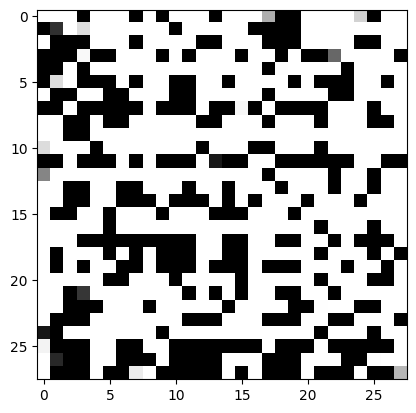

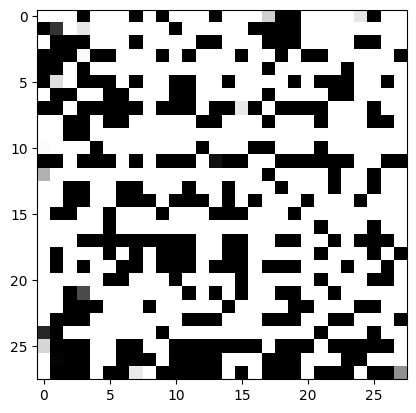

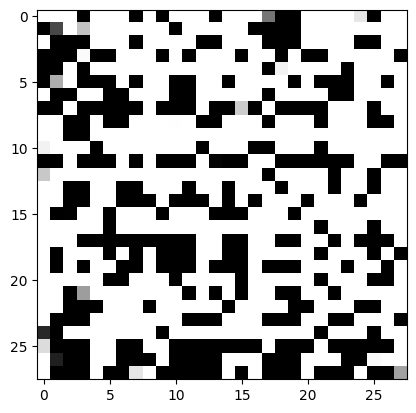

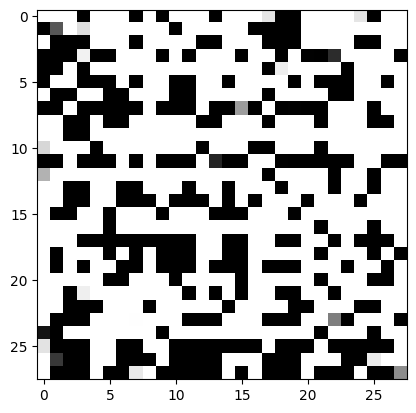

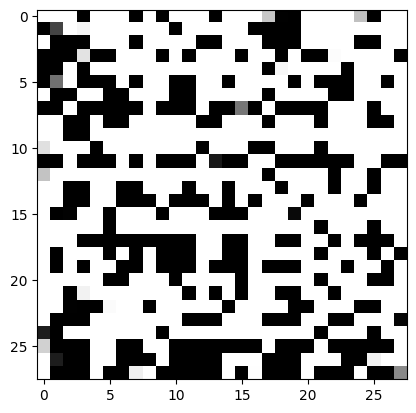

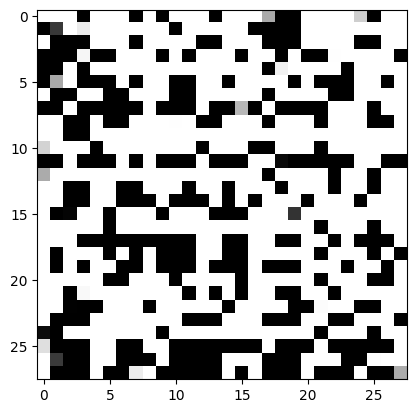

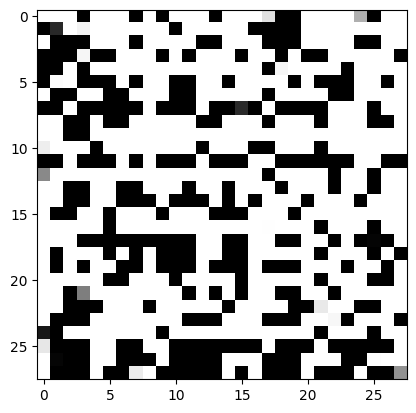

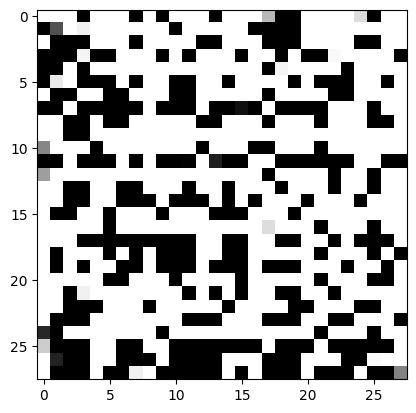

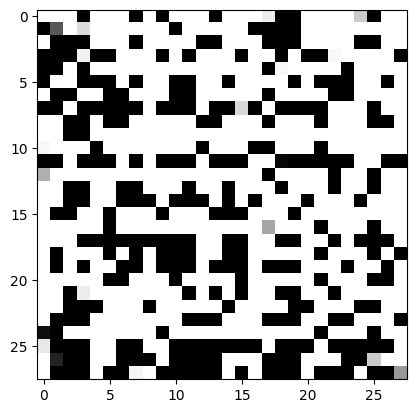

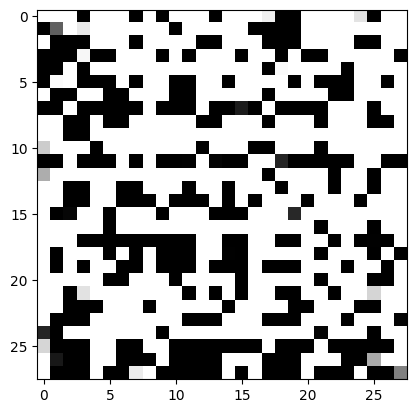

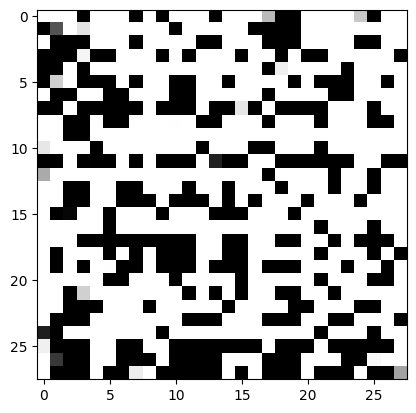

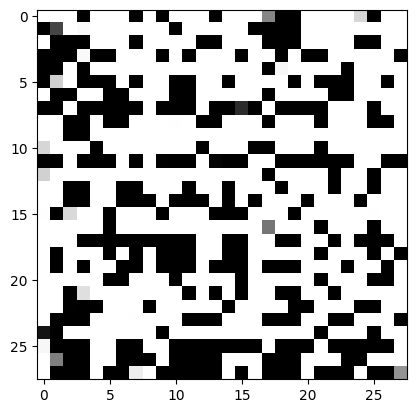

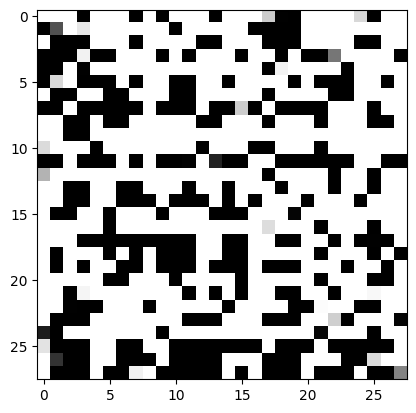

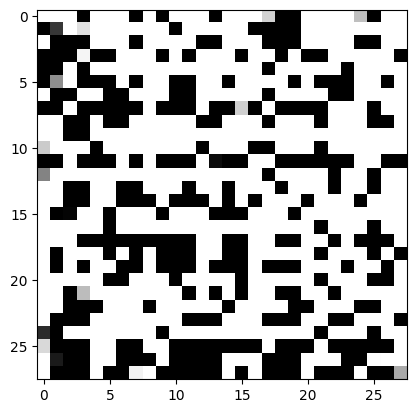

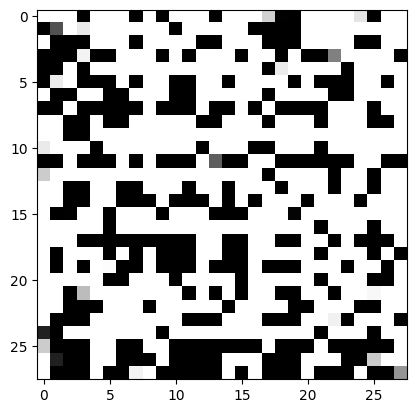

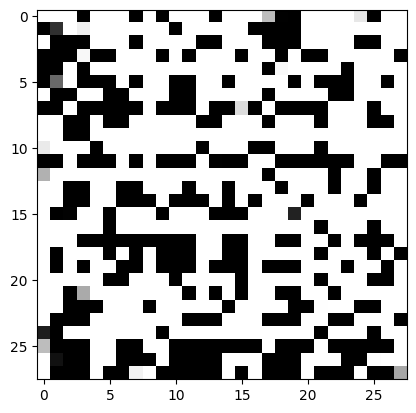

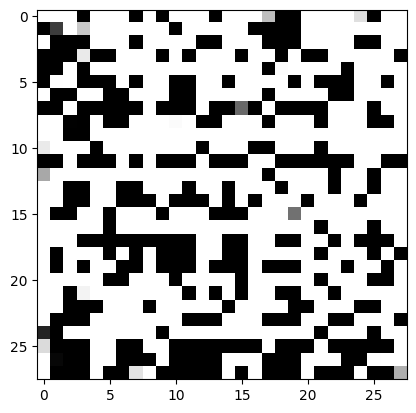

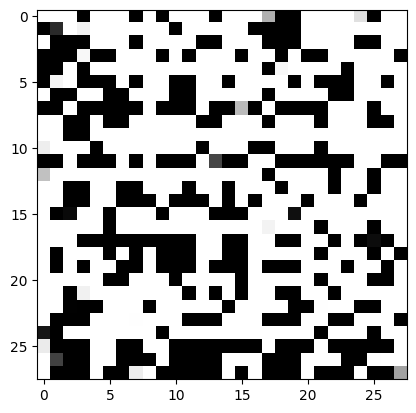

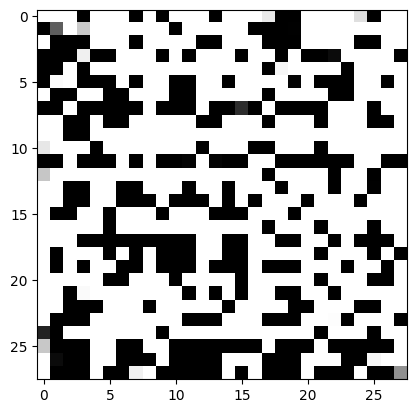

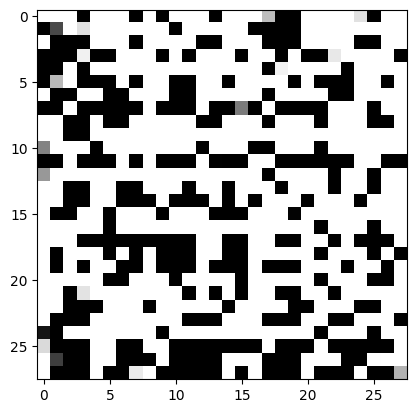

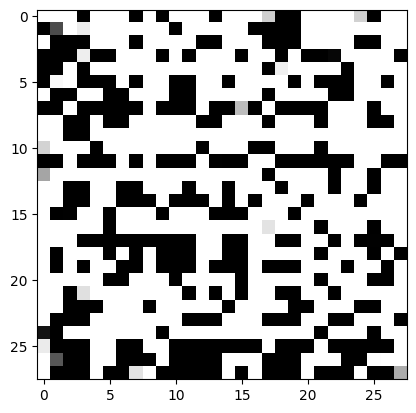

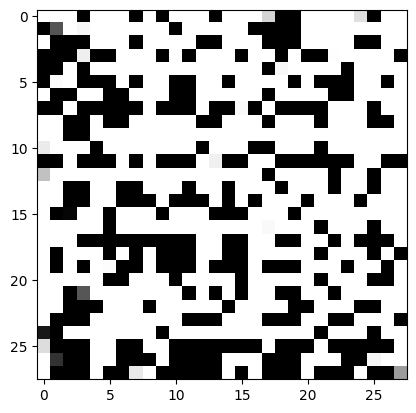

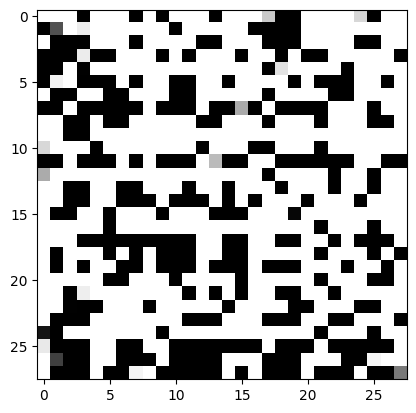

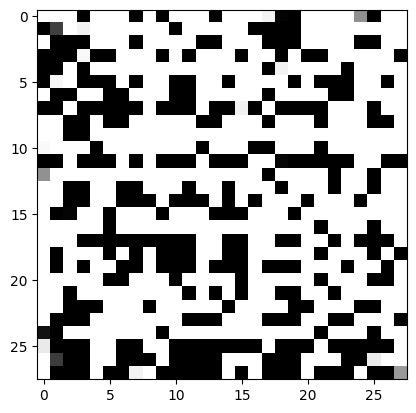

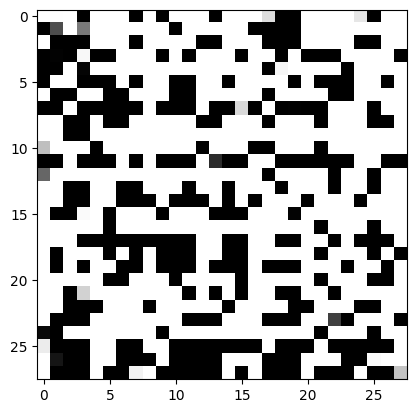

In [ ]:
for i in range(Fake_images.shape[0]):
    I = Fake_images[i,:,:,:]
    plt.imshow(I, cmap='gray', vmin=0, vmax=1)
    plt.show()
    time.sleep(0.2)